In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import random

In [3]:
spectrograms_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations'
metrics_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/metrics'

In [4]:
images = []
labels = []

fraction = 1

emotion_to_index = {
    "angry": 0,
    "happy": 1,
    "sad": 2,
    "neutral": 3,
    "fearful": 4,
    "disgust": 5,
    "surprise": 6,
}

all_files = [file for file in os.listdir(spectrograms_dir) if file.endswith(".png")]
selected_files = random.sample(all_files, int(len(all_files) * fraction))

for file_name in selected_files:
    file_path = os.path.join(spectrograms_dir, file_name)

    img = Image.open(file_path).convert("RGB")
    img = img.resize((256, 256))
    img_array = np.array(img)

    images.append(img_array)

    emotion = file_name.split("_")[1]
    label = emotion_to_index.get(emotion, -1)
    if label == -1:
        raise ValueError(f"Émotion inconnue dans le fichier : {file_name}")

    labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One-hot
num_classes = len(emotion_to_index)
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")

Ensemble d'entraînement : (2002, 256, 256, 3), (2002, 7)
Ensemble de validation : (429, 256, 256, 3), (429, 7)
Ensemble de test : (429, 256, 256, 3), (429, 7)


In [5]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # 256, 256*3
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)  # 256, 256*3
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)  # 256, 256*3

In [6]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Normalisation des entrées
    model.add(BatchNormalization(input_shape=input_shape))

    # Première couche LSTM avec retour de séquences
    model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))

    # Deuxième couche LSTM sans retour de séquences
    model.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.2))

    # Couche dense pour la classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))  # Dropout pour éviter le surapprentissage

    # Couche de sortie pour la classification multiclasse
    model.add(Dense(num_classes, activation='softmax'))

    # Compilation du modèle avec l'optimiseur Adam et la perte categorical crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (256, 256 * 3)  # 256 timesteps, 256*3 caractéristiques (RGB)
model = create_lstm_model(input_shape, num_classes)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 256, 768)            │           3,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256, 128)            │         459,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520,967 (1.99 MB)

 Trainable params: 519,431 (1.98 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [7]:
history = model.fit(
    X_train_lstm, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_lstm, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print(f"Loss on the test set: {test_loss}")
print(f"Accuracy on the test set: {test_accuracy}")

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 717ms/step - accuracy: 0.2217 - loss: 1.8852 - val_accuracy: 0.1818 - val_loss: 1.9853
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - accuracy: 0.3553 - loss: 1.6846 - val_accuracy: 0.2424 - val_loss: 1.8374
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 672ms/step - accuracy: 0.3906 - loss: 1.5865 - val_accuracy: 0.3473 - val_loss: 1.6535
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 666ms/step - accuracy: 0.4498 - loss: 1.4592 - val_accuracy: 0.4079 - val_loss: 1.5737
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - accuracy: 0.4644 - loss: 1.3984 - val_accuracy: 0.4476 - val_loss: 1.4724
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 696ms/step - accuracy: 0.4942 - loss: 1.3398 - val_accuracy: 0.4359 - val_loss: 1.4377
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 699ms/step - accuracy: 0.5186 - loss: 1.2845 - val_accuracy: 0.4592 - val_loss: 1.4337
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - accuracy: 0.5284 - loss: 1.2227 - val_accu

In [8]:
model_name = "LSTM"
model_metrics_dir = os.path.join(metrics_dir, model_name)
os.makedirs(model_metrics_dir, exist_ok=True)

In [9]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "accuracy_curve.png"))
plt.close()

In [11]:
emotion_labels = [
    "Angry", "Happy", "Sad", "Neutral", "Fearful", "Disgust", "Surprise"
]

y_pred = model.predict(X_test_lstm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CNN on Spectrograms")

conf_matrix_path = os.path.join(model_metrics_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step


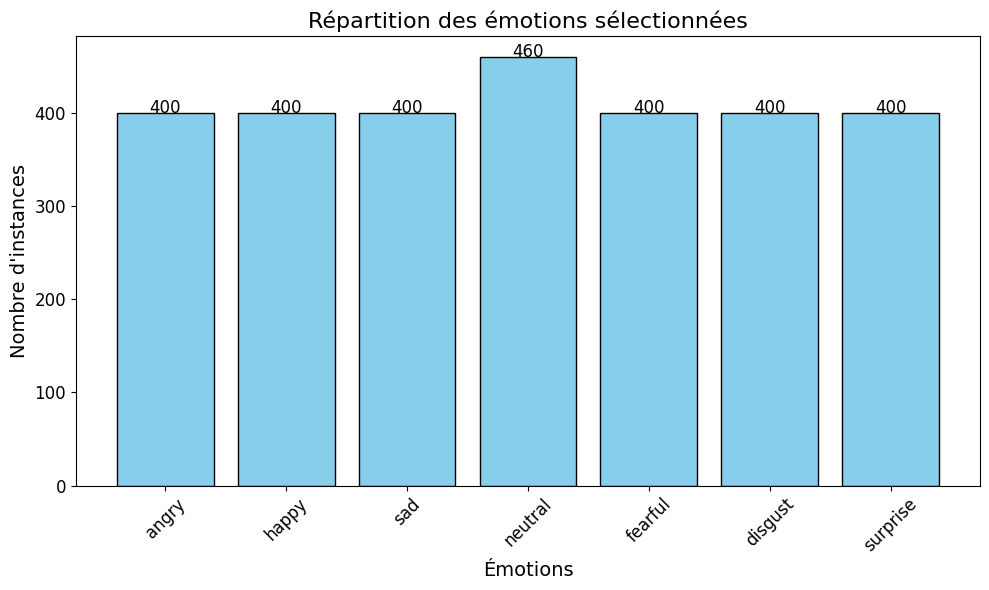

In [12]:
emotion_counts = {emotion: 0 for emotion in emotion_to_index.keys()}
for label in labels:
    emotion_name = list(emotion_to_index.keys())[list(emotion_to_index.values()).index(label)]
    emotion_counts[emotion_name] += 1

emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue', edgecolor='black')
plt.title("Répartition des émotions sélectionnées", fontsize=16)
plt.xlabel("Émotions", fontsize=14)
plt.ylabel("Nombre d'instances", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()